<a href="https://colab.research.google.com/github/inamdarmihir/researchdocs/blob/main/LinCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the basic libraries:

In [1]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 17.0 MB/s 
     |████████████████████████████████| 212 kB 70.1 MB/s 


In [2]:
import string
import re
import codecs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import feature_extraction
from sklearn import linear_model
from sklearn import pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
import warnings
warnings.simplefilter("ignore")

In [3]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.2


In [4]:
import nltk

Loading the Data:

In [6]:
data = pd.read_csv("LinCE.csv")
data.head()

,Text,Label
0,Batman vs Superman\tbatman vs superman,NaN
1,"The director is Zack Snyder, 27% Rotten Tomato...",NaN
2,Not very popular it seems\tlagta hai bahut pop...,NaN
3,But the audiences liked it. It has a B cinema ...,NaN
4,Yes\tyes,NaN


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8060 entries, 0 to 8059
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Text    8060 non-null   object 
 1   Label   0 non-null      float64
dtypes: float64(1), object(1)
memory usage: 126.1+ KB


Preprocessing the Dataset:

In [8]:
def remove_pattern(input_txt, pattern):
  r = re.findall(pattern, input_txt)
  for word in r:
    input_txt = re.sub(word, "", input_txt)
  return input_txt

In [11]:
#remove twitter handles (@user):
data['Text'] = np.vectorize(remove_pattern)(data['Text'], "@[\w]*")

In [12]:
data.head()

,Text,Label
0,Batman vs Superman\tbatman vs superman,NaN
1,"The director is Zack Snyder, 27% Rotten Tomato...",NaN
2,Not very popular it seems\tlagta hai bahut pop...,NaN
3,But the audiences liked it. It has a B cinema ...,NaN
4,Yes\tyes,NaN


In [13]:
#Removing punctuations and special characters:
data['Text'] = data['Text'].str.replace("[^a-zA-Z]", " ")
data.head()

,Text,Label
0,Batman vs Superman batman vs superman,NaN
1,The director is Zack Snyder Rotten Tomato...,NaN
2,Not very popular it seems lagta hai bahut popu...,NaN
3,But the audiences liked it It has a B cinema ...,NaN
4,Yes yes,NaN


In [14]:
#remove short words:
data['Text'] = data['Text'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
data.head()


,Text,Label
0,Batman Superman batman superman,NaN
1,director Zack Snyder Rotten Tomatoes Zack Snyd...,NaN
2,very popular seems lagta bahut popular nahi,NaN
3,audiences liked cinema score audience like kiy...,NaN
4,,NaN


In [16]:
# individual words considered as tokens
tokenized_text = data['Text'].apply(lambda x: x.split())
tokenized_text.head()

0                 [Batman, Superman, batman, superman]
1    [director, Zack, Snyder, Rotten, Tomatoes, Zac...
2    [very, popular, seems, lagta, bahut, popular, ...
3    [audiences, liked, cinema, score, audience, li...
4                                                   []
Name: Text, dtype: object

In [17]:
# stem the words
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

tokenized_text = tokenized_text.apply(lambda sentence: [stemmer.stem(word) for word in sentence])
tokenized_text.head()

0                 [batman, superman, batman, superman]
1    [director, zack, snyder, rotten, tomato, zack,...
2    [veri, popular, seem, lagta, bahut, popular, n...
3    [audienc, like, cinema, score, audienc, like, ...
4                                                   []
Name: Text, dtype: object

In [18]:
# combine words into single sentence
for i in range(len(tokenized_text)):
    tokenized_text[i] = " ".join(tokenized_text[i])
    
data['Text'] = tokenized_text

In [20]:
data.tail()

,Text,Label
8055,thik,NaN
8056,thik bhai,NaN
8057,shall continu chalu sakt,NaN
8058,like aapko pasand hamar saath,NaN
8059,yeah have fifteen thank mere pass pandrah thank,NaN


Exploratory Data Analysis:

In [21]:
#!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


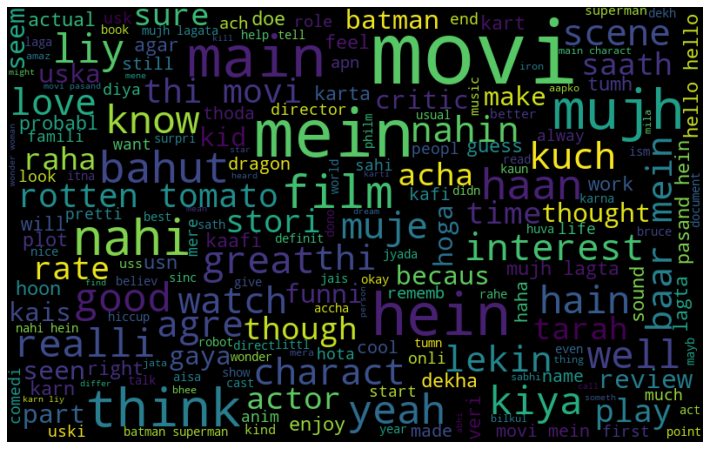

In [22]:
# visualize the frequent words in Text:
all_words = " ".join([sentence for sentence in data['Text']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()